In [1]:
# %matplotlib widget

In [1]:
from ephysvibe.structures.neuron_data import NeuronData
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import os
import glob
from ephysvibe.trials import align_trials
from ephysvibe.trials.spikes import firing_rate
import platform
from joblib import Parallel, delayed
from tqdm import tqdm
import h5py
from pathlib import Path
from typing import Dict,List
import pca_tools
from scipy import stats
seed=2024

### Define functions

In [2]:
def to_python_hdf5(dat:List, save_path: Path):
    """Save data in hdf5 format."""
    # save the data
    with h5py.File(save_path, "w") as f:
        for i_d in range(len(dat)):
            group = f.create_group(str(i_d))

            for key, value in zip(dat[i_d].keys(), dat[i_d].values()):
                group.create_dataset(key, np.array(value).shape, data=value)
    f.close()

In [3]:
def from_python_hdf5(load_path: Path):
    """Load data from a file in hdf5 format from Python."""
    with h5py.File(load_path, "r") as f:
        data = []
        for i_g in f.keys():
            group = f[i_g]
            dataset={}
            for key, value in zip(group.keys(), group.values()):
                dataset[key] = np.array(value)
            data.append(dataset)
    f.close()
    return data

In [4]:
def z_score(x):
    mu = np.mean(x,axis=0)
    sigma = np.std(x,axis=0)
    sigma0=sigma
    sigma0[sigma == 0] = 1 
    zs_x = (x-mu) / sigma0
    return zs_x

In [5]:
def get_fr_samples(sp,sample_id,start,end,samples,min_trials):
    # parameters
    win=50
    # Check fr
    ms_fr=np.nanmean(sp[:,start:end])*1000>5
    if not ms_fr:
        return None
    # Average spikes
    avg_sample = firing_rate.moving_average(sp, win=win, step = 1)
    fr_samples = []
    for s_id in samples:
        sample_fr = avg_sample[np.where(sample_id==s_id,True,False),start:end]
        # Check number of trials
        if sample_fr.shape[0]< min_trials:
            return None
        
        fr_mean = np.nanmean(sample_fr,axis=0)

        if np.any(np.isnan(fr_mean)):
            return None
        fr_samples.append(fr_mean)
    return fr_samples


In [6]:
def get_neuron_sample_fr(path,time_before,start,end,min_trials):
    neu_data = NeuronData.from_python_hdf5(path)
    select_block=1
    code=1
    idx_start = time_before + start 
    idx_end = time_before+end
    # Select trials aligned to sample onset
    sp_sample_on,mask = align_trials.align_on(
        sp_samples=neu_data.sp_samples,
        code_samples=neu_data.code_samples,
        code_numbers=neu_data.code_numbers,
        trial_error=neu_data.trial_error,
        block=neu_data.block,
        pos_code=neu_data.pos_code,
        select_block= select_block,
        select_pos= code,
        event ="sample_on",
        time_before = time_before,
        error_type= 0,
    )
    if np.sum(mask)<20:
        return {'fr':None}
    sample_id = neu_data.sample_id[mask]
    fr_samples = get_fr_samples(sp_sample_on,sample_id,start=idx_start,end=idx_end,samples=[0,11,15,55,51],min_trials=min_trials)
    if fr_samples is None:
        return {'fr':None}
    return {'fr':fr_samples}

In [7]:
def check_triasl(sp,idx_start,idx_end):
    sig_trials = np.sum(sp,axis=1)>0
    return sig_trials

In [8]:
def select_trials(neu_data,select_block,code,time_before,error_type=0):
    sp_sample_on, mask_sample = align_trials.align_on(
        sp_samples=neu_data.sp_samples,
        code_samples=neu_data.code_samples,
        code_numbers=neu_data.code_numbers,
        trial_error=neu_data.trial_error,
        block=neu_data.block,
        pos_code=neu_data.pos_code,
        select_block= select_block,
        select_pos= code,
        event ="sample_on",
        time_before = time_before,
        error_type= error_type,
    )
    sp_test1_on, mask_test1 = align_trials.align_on(
        sp_samples=neu_data.sp_samples,
        code_samples=neu_data.code_samples,
        code_numbers=neu_data.code_numbers,
        trial_error=neu_data.trial_error,
        block=neu_data.block,
        pos_code=neu_data.pos_code,
        select_block= select_block,
        select_pos= code,
        event ="test_on_1",
        time_before = 200,
        error_type= error_type,
    )
    if np.any(mask_sample != mask_test1):
        return "error"
    return sp_sample_on,sp_test1_on,mask_sample,mask_test1

In [41]:
def align_all_trials_all_epochs(sp_sample_on,code_samples,time_before):
    alig = np.full((sp_sample_on.shape[0],sp_sample_on.shape[1]+1000),np.nan)
    t_s_off = ((code_samples[:,5] - code_samples[:,4] )+time_before).astype(int).tolist()
    t_d_off = ((code_samples[:,6] - code_samples[:,4] )+time_before).astype(int).tolist()
    max_dur_s = np.max(t_s_off)
    max_dur_d = max_dur_s+600#np.max(t_d_off)
    t_d_off=np.where(t_d_off>max_dur_d,max_dur_d,t_d_off)
    for i in range(len(t_s_off)):
        # sample
        alig[i,:t_s_off[i]] = sp_sample_on[i,:t_s_off[i]]
        # delay
        alig[i,max_dur_s:max_dur_s+(t_d_off[i]-t_s_off[i])] = sp_sample_on[i,t_s_off[i]:t_d_off[i]]
        # test
        alig[i,max_dur_d:max_dur_d+(sp_sample_on.shape[1]-t_d_off[i])] = sp_sample_on[i,t_d_off[i]:]

    return alig

In [42]:
def get_neuron_sample_align_fr(path,time_before,start,end,end_test,n_test,min_trials,nonmatch=True):
    neu_data = NeuronData.from_python_hdf5(path)
    select_block=1
    code=1
    idx_start = time_before + start 
    idx_end = time_before+end
    # Select trials aligned to sample onset
    sp_sample_on,sp_test1_on,mask_sample,mask_test1 = select_trials(neu_data,select_block,code,time_before,error_type=0)
    code_samples=neu_data.code_samples[mask_sample]
    alig = align_all_trials_all_epochs(sp_sample_on,code_samples,time_before)

    mask_match=np.where(neu_data.test_stimuli[mask_test1,n_test-1]==neu_data.sample_id[mask_test1],True,False)
    mask_neu = neu_data.sample_id[mask_test1]==0
    max_test = neu_data.test_stimuli[mask_test1].shape[1]
    mask_ntest = (max_test-np.sum(np.isnan(neu_data.test_stimuli[mask_test1]),axis=1))>(n_test-1)
    #mask_match_neu = np.logical_or(mask_match,mask_neu)
    #mask_match_neu = np.logical_or(np.full(mask_neu.shape,True),mask_neu)
    if nonmatch:
        mask_match_neu = np.logical_or(mask_ntest,mask_neu) 
    else:
        mask_match_neu = np.logical_or(mask_match,mask_neu)
    if np.sum(mask_match_neu)<20:
        return {'fr':None}
    sp = alig[mask_match_neu]
    sample_id = neu_data.sample_id[mask_test1][mask_match_neu]
    fr_samples = get_fr_samples(sp,sample_id,start=idx_start,end=idx_end,samples=[0,11,15,55,51],min_trials=min_trials)
    if fr_samples is None:
        return {'fr':None}
    return {'fr':fr_samples}

In [43]:
neu_data = NeuronData.from_python_hdf5(path_list[500])
select_block=1
code=1
idx_start = time_before + start 
idx_end = time_before+end
# Select trials aligned to sample onset
sp_sample_on,sp_test1_on,mask_sample,mask_test1 = select_trials(neu_data,select_block,code,time_before,error_type=0)
code_samples=neu_data.code_samples[mask_sample]
alig = align_all_trials_all_epochs(sp_sample_on,code_samples,time_before)

In [38]:
t_s_off = ((code_samples[:,5] - code_samples[:,4] )+time_before).astype(int).tolist()
t_d_off = ((code_samples[:,6] - code_samples[:,5] )).astype(int).tolist()
max_dur_s = np.max(t_s_off)
max_dur_d = np.max(t_d_off)

In [39]:
max_dur_d

765

In [40]:
np.min(t_d_off)

564

### Read data

In [44]:
if platform.system() == 'Linux':
    basepath = '/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/new_structure/'
elif platform.system() == 'Windows':
    basepath = 'C:/Users/camil/Documents/int/'

In [45]:
area='lip'
neu_path = basepath+'/session_struct/'+area+'/neurons/*neu.h5'
path_list = glob.glob(neu_path)

In [46]:
# Load data
n_test=1
min_trials=10
nonmatch=False
time_before=500
start=-200
end_test = n_test*450
end=450+650+end_test

idx_start = time_before + start 
idx_end = time_before+end

In [47]:
idx_end-idx_start

1750

In [48]:
pp = []
for path in path_list:
    pp.append(path.rsplit('Riesling')[1])

In [49]:
data = Parallel(n_jobs = -1)(delayed(get_neuron_sample_align_fr)(path,time_before,start,end,end_test,n_test,min_trials,nonmatch) for path in tqdm(path_list))

100%|██████████| 530/530 [02:23<00:00,  3.70it/s]


In [50]:
neurons_fr = []
for asc in data:
    fr = asc["fr"]
    if fr is not None:
        neurons_fr.append(asc)
basepath = './' #'/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/pca/data/'+area +'/'
to_python_hdf5(dat=neurons_fr, save_path=basepath+area+'_win50_test'+str(n_test)+'_match_min'+str(min_trials)+'tr_pca.h5')

In [51]:
neurons_fr_read=from_python_hdf5(load_path=basepath+area+'_win50_test'+str(n_test)+'_match_min'+str(min_trials)+'tr_pca.h5')
neurons_fr = []
for asc in neurons_fr_read:
    fr = asc["fr"]
    if fr is not None:
        fr_concat = np.concatenate(fr,axis=0)
        neurons_fr.append(fr_concat)

In [52]:
neurons_fr = np.array(neurons_fr)#.reshape(-1,1050)
neurons_fr.shape

(166, 8750)

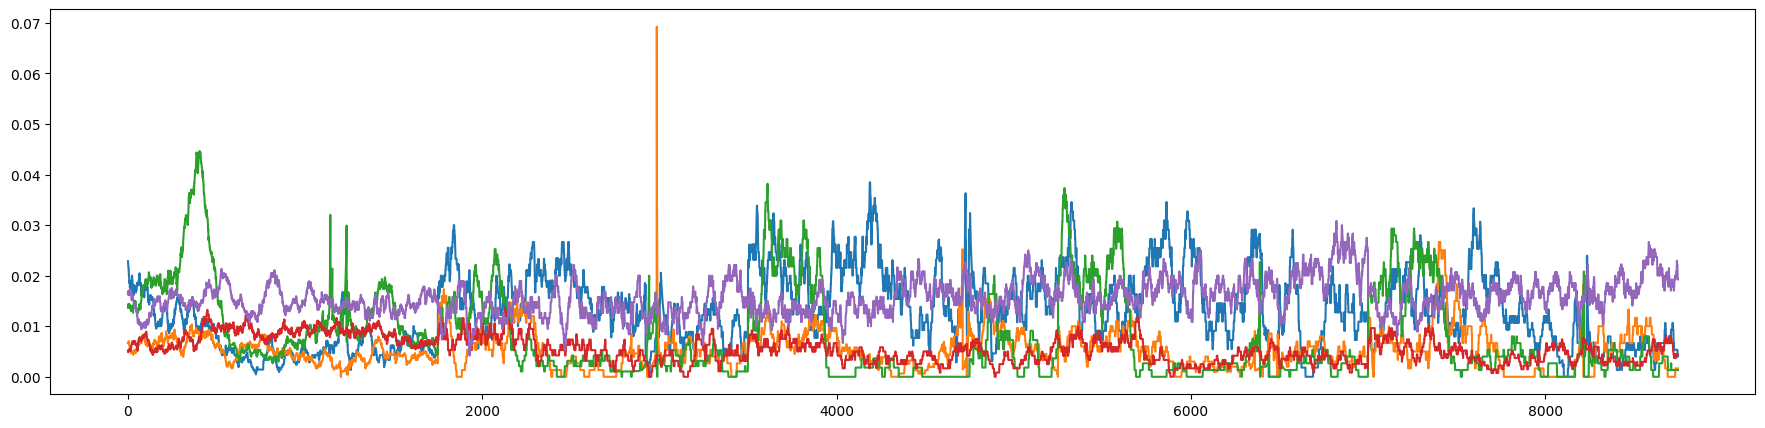

In [53]:
plt.subplots(figsize=(22,5))
_=plt.plot(neurons_fr[0:5].T)

lip: 7 components to explain 80% of the variance


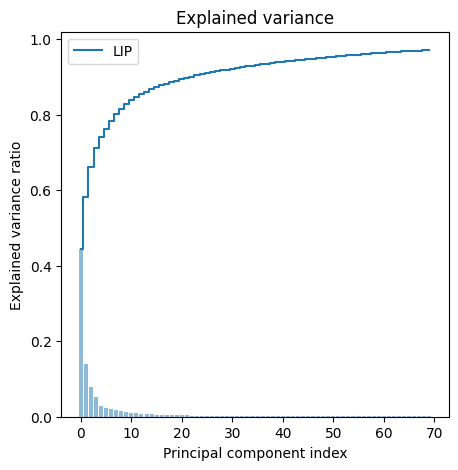

In [54]:
n_comp=70
model,pc_s = pca_tools.compute_pca(neurons_fr,n_comp=n_comp)
pca_tools.plot_explained_var(model,figsize=(5,5),area=area)

In [55]:

# Define epochs
test1_st =200+450+450
test2_st = test1_st+450
test3_st = test2_st+450
test4_st = test3_st+450
test5_st = test4_st+450
idx_f = np.arange(0,200,2)
idx_s = np.arange(200,200+450,2)
idx_d = np.arange(200+450,test1_st,2)
idx_t1 = np.arange(test1_st,test2_st,2)
idx_t2 = np.arange(test2_st,test3_st,2)
idx_t3 = np.arange(test3_st,test4_st,2)
idx_t4 = np.arange(test4_st,test5_st,2)
idx_aftert = np.arange(test2_st,end-start,2)

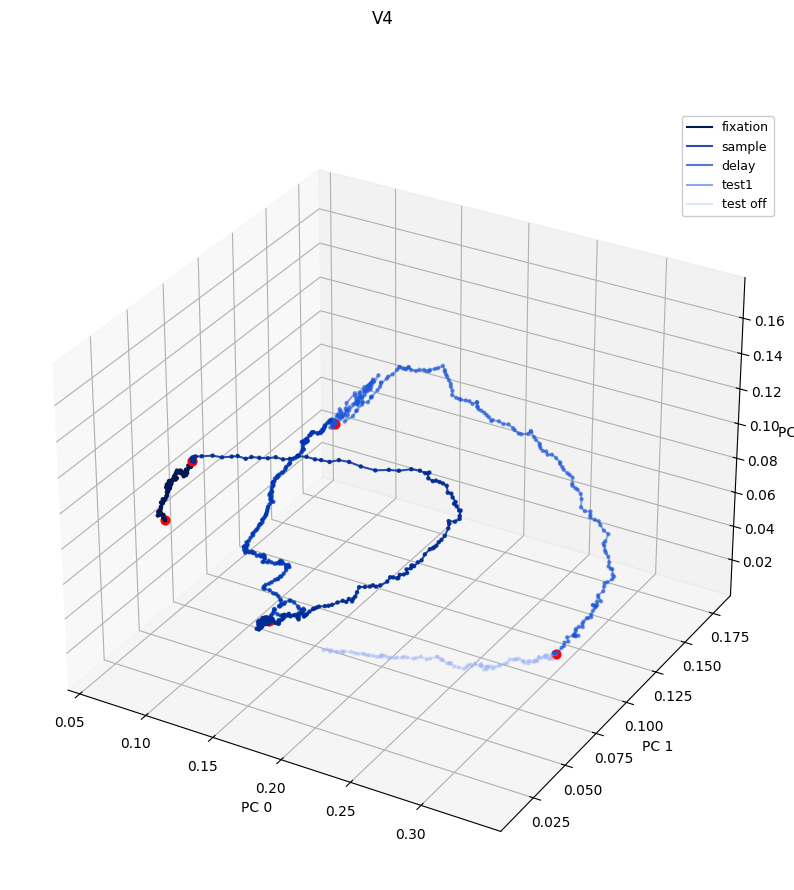

In [66]:
greyscale=['#000000','#0F0F0F','#3D3D3D','#6B6B6B','#7A7A7A','#999999','#C7C7C7','#D6D6D6']
colors_g=['#001755','#002B95','#0036B3','#1A54D8','#3566DF','#4F79E5','#84A0F0','#9EB4F5']
t_epochs = {'fixation':idx_f,'sample':idx_s,'delay':idx_d,'test1':idx_t1,'test off':idx_aftert}#
colors = {'epochs':{'fixation':colors_g[0],'sample':colors_g[1],'delay':colors_g[2],'test1':colors_g[3],'test2':colors_g[4],'test3':colors_g[5],'test4':colors_g[6],'test off':colors_g[-1]}}

reshape_pc_s = pc_s.reshape(n_comp,-1,end-start)
mean_pc_s= np.mean(reshape_pc_s[:,1:,:],axis=1)
pca_tools.plot_pc_3d(mean_pc_s,colors,t_epochs,'v4',figsize=(10,10))

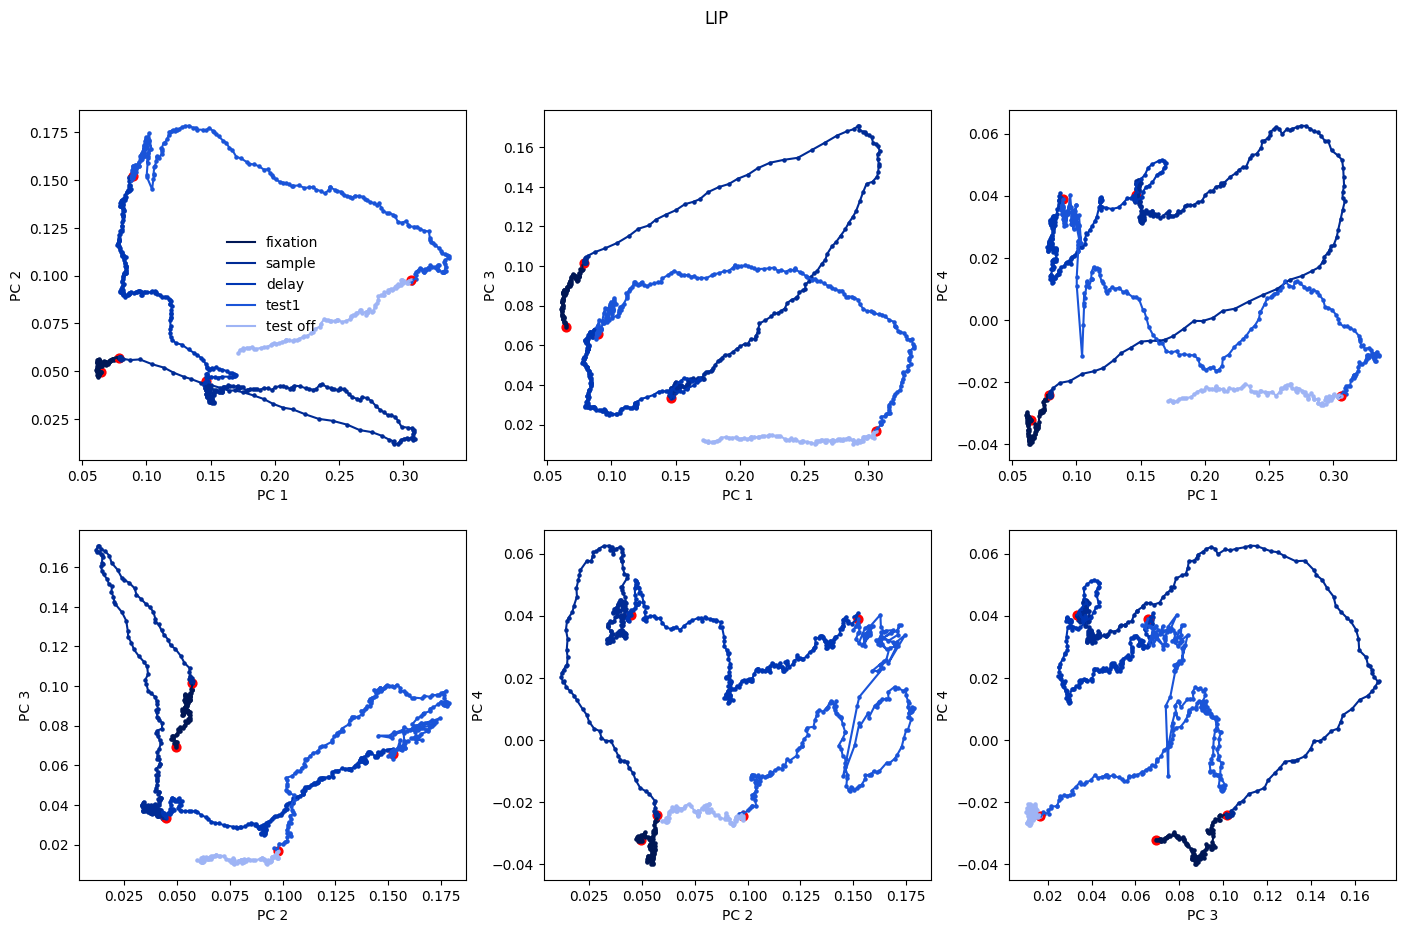

In [64]:
mean_pc_s= np.mean(reshape_pc_s[:,1:,:],axis=1)
fig, ax = plt.subplots(2, 3, figsize=(17,10))
pca_tools.plot_pc(mean_pc_s,colors,t_epochs,'lip',sample_flag = False,fig=fig, ax=ax)